In [1]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [3]:
smiles = [
    "CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N1)C(C(C)CC=CC)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C",
    "CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CCCC2(C)C)C)C)C",
    "CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O",
]
names = ["cyclosporine", "clozapine", "beta-carotene", "cannabidiol"]

,name,smiles,ROMol
0,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,
1,clozapine,CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C,
2,beta-carotene,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,
3,cannabidiol,CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O,

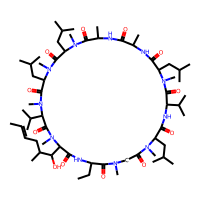
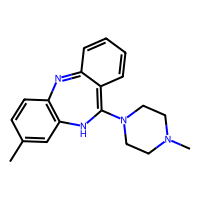
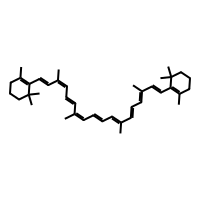
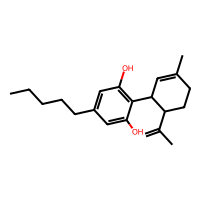

In [4]:
molecules = pd.DataFrame({"name": names, "smiles": smiles})
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")
molecules

In [5]:
molecules["molecular_weight"] = molecules["ROMol"].apply(Descriptors.ExactMolWt)
molecules["n_hba"] = molecules["ROMol"].apply(Descriptors.NumHAcceptors)
molecules["n_hbd"] = molecules["ROMol"].apply(Descriptors.NumHDonors)
molecules["logp"] = molecules["ROMol"].apply(Descriptors.MolLogP)
# Colors are used for plotting the molecules later
molecules["color"] = ["red", "green", "blue", "cyan"]
# NBVAL_CHECK_OUTPUT
molecules[["molecular_weight", "n_hba", "n_hbd", "logp"]]

,molecular_weight,n_hba,n_hbd,logp
0,1201.841368,12,5,3.26900
1,306.184447,4,1,1.68492
2,536.438202,0,0,12.60580
3,314.224580,2,2,5.84650


,name,smiles,ROMol,molecular_weight,n_hba,n_hbd,logp,color
0,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,,1201.841368,12,5,3.26900,red
1,clozapine,CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C,,306.184447,4,1,1.68492,green
2,beta-carotene,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,,536.438202,0,0,12.60580,blue
3,cannabidiol,CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O,,314.224580,2,2,5.84650,cyan

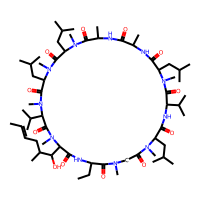
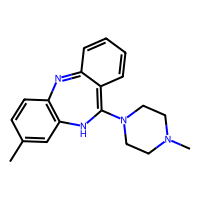
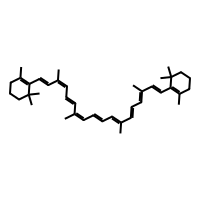
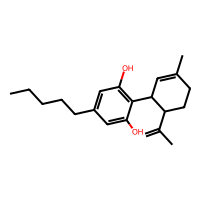

In [6]:
molecules

In [7]:
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

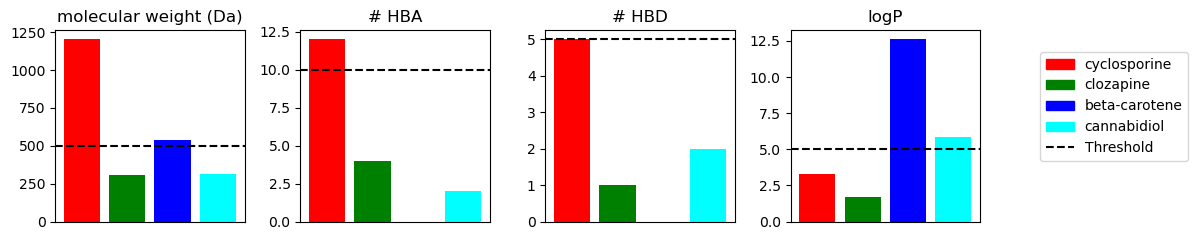

In [11]:
# Start 1x4 plot frame
fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4)
x = np.arange(1, len(molecules) + 1)
colors = ["red", "green", "blue", "cyan"]

# Create subplots
for index, (key, (threshold, title)) in enumerate(ro5_properties.items()):
    axes[index].bar([1, 2, 3, 4], molecules[key], color=colors)
    axes[index].axhline(y=threshold, color="black", linestyle="dashed")
    axes[index].set_title(title)
    axes[index].set_xticks([])

# Add legend
legend_elements = [
    mpatches.Patch(color=row["color"], label=row["name"]) for index, row in molecules.iterrows()
]
legend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.2, 0.8))

# Fit subplots and legend into figure
plt.tight_layout()
plt.show()

In [14]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

In [15]:
# NBVAL_CHECK_OUTPUT
for name, smiles in zip(molecules["name"], molecules["smiles"]):
    print(f"Ro5 fulfilled for {name}: {calculate_ro5_properties(smiles)['ro5_fulfilled']}")

Ro5 fulfilled for cyclosporine: False
Ro5 fulfilled for clozapine: True
Ro5 fulfilled for beta-carotene: False
Ro5 fulfilled for cannabidiol: True


In [18]:
molecules = pd.read_csv("./data/EGFR_compounds.csv", index_col=0)
print(molecules.shape)
molecules.head()

(7074, 5)


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
4,CHEMBL5270693,0.008,nM,COc1cc(N2CCC(N(C)C)CC2)ccc1Nc1ncc(C(=O)Oc2cccc...,11.096910


In [19]:
# This takes a couple of seconds
ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,349.021459,3,1,5.2891,True
1,343.043258,5,1,3.5969,True
2,387.058239,5,1,4.9333,True
3,329.027607,5,2,3.5726,True
4,562.269239,8,2,6.1267,False


In [20]:
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,True
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True
4,CHEMBL5270693,0.008,nM,COc1cc(N2CCC(N(C)C)CC2)ccc1Nc1ncc(C(=O)Oc2cccc...,11.096910,562.269239,8,2,6.1267,False


In [21]:
# Note that the column "ro5_fulfilled" contains boolean values.
# Thus, we can use the column values directly to subset data.
# Note that ~ negates boolean values.
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")
# NBVAL_CHECK_OUTPUT

# compounds in unfiltered data set: 7074
# compounds in filtered data set: 5603
# compounds not compliant with the Ro5: 1471


In [22]:
# Save filtered data
molecules_ro5_fulfilled.to_csv(DATA / "EGFR_compounds_lipinski.csv")
molecules_ro5_fulfilled.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,True
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True
5,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,True


In [32]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats


In [33]:
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,420.704807,88.481425
n_hba,6.134392,1.906312
n_hbd,1.906657,1.014900
logp,4.068309,1.175747


In [35]:
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_violated_stats

,mean,std
molecular_weight,592.293120,97.187039
n_hba,8.247451,2.239097
n_hbd,2.189667,1.499225
logp,5.879671,1.336260


**radar ploting**


y 값 준비 : Ro5 기준에 사용된 속성은 크기가 다릅니다. MWT는 임계값이 500 인 반면, HBA와 HBD의 수와 LogP는 각각 10, 5, 5의 임계값만 있습니다 . 이러한 다양한 스케일을 가장 단순하게 시각화하기 위해 모든 속성 값을 스케일된 임계값 5 로 스케일합니다 .

scaled property value= / *property valueproperty thresholdscaled property threshold

확장된 MWT = MWT / 500 * 5 = MWT / 100

확장된 HBA = HBA / 10 * 5 = HBA / 2

확장된 HBD = HBD / 5 * 5 = HBD

스케일된 LogP = LogP / 5 * 5 = LogP

이로 인해 MWT는 100만큼 감소하고 HBA는 2만큼 감소하지만 HBD와 LogP는 변경되지 않습니다.

In [36]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

In [42]:
# radar plot의 물리화학적 속성 4가지의 축의 각도를 나타내기
# radian 사용

def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [43]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = pd.concat([y, y.head(1)])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * len(x), "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In [39]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

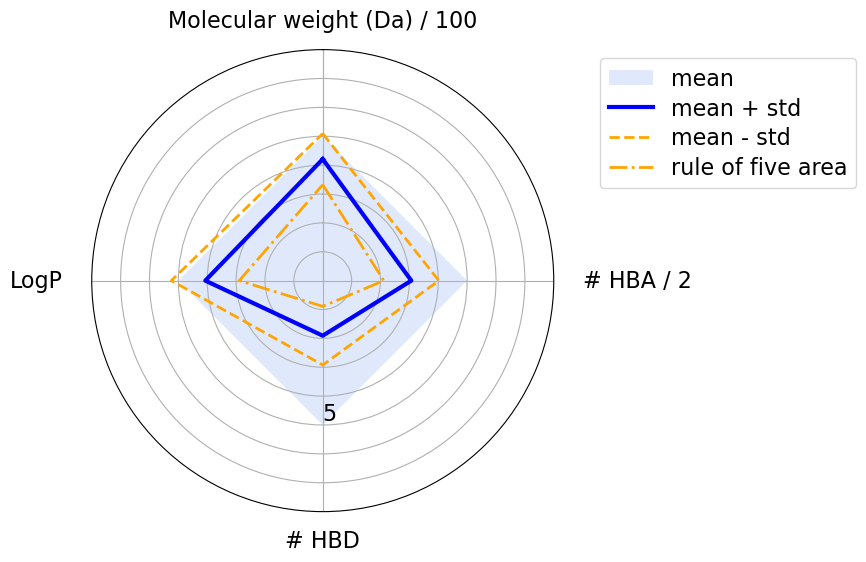

In [40]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

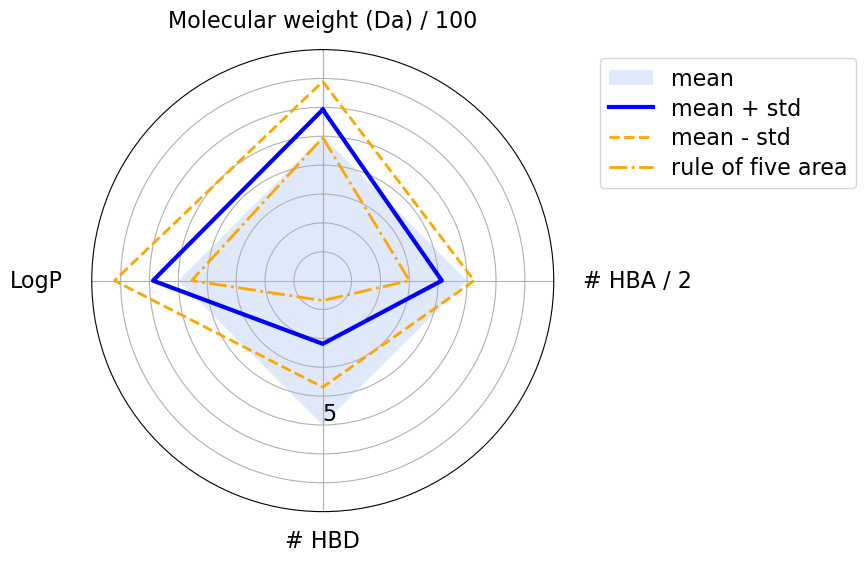

In [41]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)